# Dataset Explanation for Market Basket Analysis

### We used three main CSV files from the Instacart Online Grocery Shopping Dataset, each representing a different aspect of customer purchasing behavior.


### 1. orders.csv — Customer Purchase History

#### Purpose: This file contains details about every order placed by each user. It describes who ordered, when, and in which sequence the order occurred.

| Column                   | Description                                                           |
| ------------------------ | --------------------------------------------------------------------- |
| `order_id`               | Unique ID assigned to each order.                                     |
| `user_id`                | ID of the user who placed that order.                                 |
| `eval_set`               | Indicates the type of order: `'prior'`, `'train'`, or `'test'`.       |
| `order_number`           | Sequential number of the order for that user (1 = first order).       |
| `order_dow`              | Day of week the order was placed (0=Sunday, 6=Saturday).              |
| `order_hour_of_day`      | Hour of the day (0–23) when the order was placed.                     |
| `days_since_prior_order` | Number of days since the user’s previous order (NaN for first order). |

### 2. order_products__train.csv — Products Purchased per Order 

#### Purpose:This file lists which products were included in each order. It links order_id from orders.csv to specific product_ids from products.csv.

| Column              | Description                                           |
| ------------------- | ----------------------------------------------------- |
| `order_id`          | The order this product belongs to.                    |
| `product_id`        | The specific product purchased in that order.         |
| `add_to_cart_order` | The sequence in which the item was added to the cart. |
| `reordered`         | 1 if the user has bought this product before, else 0. |

### 3. products.csv — Product Catalog

#### Purpose: This is a reference file that provides human-readable names and categories for each product_id.

| Column          | Description                                           |
| --------------- | ----------------------------------------------------- |
| `product_id`    | Unique ID of each product.                            |
| `product_name`  | Descriptive product name.                             |
| `aisle_id`      | Aisle (in the store) where the product is located.    |
| `department_id` | Department category (e.g., dairy, beverages, snacks). |


## Part A: Data Preprocessing

###  1. Form the Transactional Dataset 

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import random

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
orders = pd.read_csv('archive/orders.csv')                        # contains eval_set
order_products = pd.read_csv('archive/order_products__train.csv') # products for 'train' eval set
products = pd.read_csv('archive/products.csv')                    # id -> name mapping

# get train order_ids
# Filters orders.csv to only include rows where eval_set == 'train'.
# Extracts the order_id values for these rows.
# Converts them into a set for faster filtering.
# So now train_order_ids contains all order IDs that belong to the training subset.
train_order_ids = set(orders[orders['eval_set'] == 'train']['order_id']) 

# filter order_products to only training orders
# This keeps only rows in order_products__train.csv whose order_id appears in the list of training orders.
op_train = order_products[order_products['order_id'].isin(train_order_ids)]

# group into transactions (list of product_id lists)
# Groups all product_ids belonging to the same order_id together → one list per order.
transactions = op_train.groupby('order_id')['product_id'].apply(list).tolist()

# remove duplicates within a transaction (if present) while preserving order
transactions = [list(dict.fromkeys(tx)) for tx in transactions]

print(f"Total transactions (train orders): {len(transactions)}")
print("Sample transaction (product_ids):", transactions[0])


Total transactions (train orders): 131209
Sample transaction (product_ids): [49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035]


### 2. Split the Data

In [9]:
train_tx, test_tx = train_test_split(transactions, test_size=0.2, random_state=42)
print(f"Total transactions: {len(transactions)}")
print(f"Training set size (80%): {len(train_tx)}")
print(f"Test set size (20%): {len(test_tx)}")

Total transactions: 131209
Training set size (80%): 104967
Test set size (20%): 26242


##  Part B: Association Rule Mining

### 1. Mine for Rules

In [10]:
from collections import Counter

class FPNode: # Each FPNode represents one item (e.g., “Milk”) in the FP-Tree.
    """Node in FP-Tree"""
    def __init__(self, item, count=0, parent=None):
        self.item = item # Item name (e.g., 'Milk')
        self.count = count  # How many transactions reach this node
        self.parent = parent # Link to the node above it
        self.children = {} # Dictionary mapping of item → child node
        self.node_link = None # Link to next node with same item
    
    def increment(self, count=1):
        self.count += count

class FPTree:
    """FP-Tree implementation"""
    def __init__(self, transactions, min_support_count):
        self.min_support_count = min_support_count # stores the threshold for filtering infrequent items.
        self.root = FPNode('root')  # creates the root node of the FP-tree (this root doesn’t represent any item — it’s just the starting point).
        self.header_table = {} # self.header_table: dictionary to store info about frequent items (used for linking nodes later).
        self.item_counts = Counter() # self.item_counts = Counter(): keeps a count of how many times each item appears in all transactions.
        
        # First pass: count frequencies
        # Loops through every transaction and every item within it.
        # Counts how many times each item appears overall.
        for transaction in transactions:
            for item in transaction:
                self.item_counts[item] += 1
        
        # Build header table with frequent items
        # Only include frequent items (that meet the minimum support count).
        # Create a header table entry for each frequent item:
        # 'count': total frequency
        # 'head': link to the first node in the FP-tree that represents this item (initially None)
        for item, count in self.item_counts.items():
            if count >= min_support_count:
                self.header_table[item] = {'count': count, 'head': None}
        
        # Second pass: build tree
        for transaction in transactions:
            # Filter and sort transaction by frequency (descending)
            #  Removes items not in the header table
            filtered = [item for item in transaction if item in self.header_table]
            # Items are sorted descending by count, so most frequent items come first.
            filtered.sort(key=lambda x: self.header_table[x]['count'], reverse=True)
            # If transaction is not empty, it is inserted into the tree
            # This recursively creates or updates nodes in the FP-tree, connecting them hierarchically.
            if filtered:
                self._insert_transaction(filtered, self.root)
    
    
    def _insert_transaction(self, transaction, node):
        # If the transaction is empty, stop recursion (nothing to insert).
        if not transaction:
            return
        
        # We take the first item in the list (because the transaction is sorted by frequency before this).
        first_item = transaction[0]
        
        # Check if this item already exists as a child of the current node
        # If the current node already has a child node with this item,
        # we increase its count by 1 (because another transaction also passed through this item).
        if first_item in node.children:
            node.children[first_item].increment()
        # If that item does not exist yet, create a new FPNode:
        # item = first_item
        # count = 1 (first time appearing in this path)
        # parent = node (the current node is its parent)
        else:
            # Create new node
            new_node = FPNode(first_item, 1, node)
            node.children[first_item] = new_node
            
            # Update header table links
            # Purpose: Each item (like 'milk') can appear in multiple parts of the FP-tree.
            # The header table connects all those 'milk' nodes together using node_link.

            # If it’s the first 'milk' node ever → set the header’s head pointer to it.
            if self.header_table[first_item]['head'] is None:
                self.header_table[first_item]['head'] = new_node
            # If not → find the end of the linked list (node_link) and attach this new node there.
            else:
                # Add to linked list
                current = self.header_table[first_item]['head']
                while current.node_link is not None:
                    current = current.node_link
                current.node_link = new_node
        
        # Recursively insert remaining items
        # This calls the same function again with:
        # The rest of the items in the transaction (excluding the first)
        # The current child node (so the next items go below the current item)
        self._insert_transaction(transaction[1:], node.children[first_item])
    


    def get_prefix_paths(self, item):
        """
        Get all paths ending with the given item
        This function collects all prefix paths in the FP-tree that lead to a given item.
        These paths are called conditional pattern bases in FP-Growth terminology.
        Each path comes with a count, which is how many transactions pass through this path.
        """
        paths = [] # paths will store all prefix paths for this item.
        node = self.header_table.get(item, {}).get('head') # node points to the first occurrence of item in the FP-tree (using the header table). If item = 'bread', node points to the first 'bread' node in the tree.
        
        # There can be multiple nodes for 'bread' in different branches.
        # We’ll traverse them using node.node_link.
        while node is not None: 
            path = [] # path will store all items above this node.
            count = node.count # count stores how many times this node appears in transactions (used later for conditional FP-tree).
            current = node.parent # lets us start going up the tree.
            
            while current.item != 'root': # Keep moving upwards until we reach the root.
                path.append(current.item) # Append each item to path
                current = current.parent # The path is collected from child to parent, so it will be reversed later.
            
            # Include even empty paths (when node is direct child of root)
            paths.append((path[::-1], count))
            node = node.node_link # Move to the next node of the same item using the linked list in header table.
        
        return paths # Returns a list of all prefix paths and their counts.

def fp_growth(transactions, min_support_count):
    """FP-Growth algorithm"""
    frequent_itemsets = []
    
    def mine_tree(tree, suffix=[]):
        if not tree.header_table:
            return
        
        # Process items in increasing frequency order
        items = sorted(tree.header_table.keys(), 
                      key=lambda x: tree.header_table[x]['count'])
        
        for item in items:
            # Create new frequent itemset
            new_itemset = suffix + [item]
            support = tree.header_table[item]['count']
            frequent_itemsets.append((frozenset(new_itemset), support))
            
            # Get conditional pattern base
            prefix_paths = tree.get_prefix_paths(item)
            
            if prefix_paths:
                # Build conditional transactions
                conditional_txns = []
                for path, count in prefix_paths:
                    conditional_txns.extend([path] * count)
                
                if conditional_txns:
                    # Build and mine conditional FP-tree
                    conditional_tree = FPTree(conditional_txns, min_support_count)
                    if conditional_tree.header_table:
                        mine_tree(conditional_tree, new_itemset)
    
    # Build initial tree and mine
    fp_tree = FPTree(transactions, min_support_count)
    mine_tree(fp_tree)
    
    return frequent_itemsets

def generate_association_rules_CORRECT(frequent_itemsets, transactions, min_confidence):
    """
    CORRECT rule generation with proper lift calculation  """
    rules = []
    total_transactions = len(transactions)
    
    # Build support dictionary from mined itemsets
    support_dict = {itemset: support for itemset, support in frequent_itemsets}
    
    for itemset, support_count in frequent_itemsets:
        if len(itemset) < 2:
            continue
        
        # Generate rules with single-item antecedents
        for item in itemset:
            antecedent = frozenset([item])
            consequent = itemset - antecedent
            
            if not consequent:
                continue
            
            # Get support counts
            antecedent_support = support_dict.get(antecedent, 0)
            consequent_support = support_dict.get(consequent, 0)
            
            if antecedent_support == 0 or consequent_support == 0:
                continue
            
            # Calculate confidence: P(B|A) = P(A ∩ B) / P(A)
            confidence = support_count / antecedent_support
            
            if confidence >= min_confidence:
                # Calculate probabilities
                prob_itemset = support_count / total_transactions
                prob_antecedent = antecedent_support / total_transactions
                prob_consequent = consequent_support / total_transactions
                
                # Calculate lift: P(A ∩ B) / (P(A) × P(B))
                lift = prob_itemset / (prob_antecedent * prob_consequent)
                
                rules.append({
                    'antecedent': antecedent,
                    'consequent': consequent,
                    'support': prob_itemset,
                    'confidence': confidence,
                    'lift': lift,
                    'support_count': support_count,
                    'antecedent_support': antecedent_support,
                    'consequent_support': consequent_support
                })
    
    return rules


# Apply FP-Growth
min_support = 0.003
min_support_count = int(min_support * len(train_tx))
print(f"Minimum support count: {min_support_count}")

print("Mining frequent itemsets with FP-Growth...")
frequent_itemsets = fp_growth(train_tx, min_support_count)
print(f"Found {len(frequent_itemsets)} frequent itemsets")

# Generate association rules
min_confidence = 0.06
print("Generating association rules...")
rules_list = generate_association_rules_CORRECT(frequent_itemsets, train_tx, min_confidence)

# Filter rules to keep only single-item antecedents
rules_list = [rule for rule in rules_list if len(rule['antecedent']) == 1]
print(f"Generated {len(rules_list)} rules with single-item antecedents")

# Convert to DataFrame
rules_data = []
id_to_name = pd.Series(products.product_name.values, index=products.product_id).to_dict()

for rule in rules_list:
    antecedent_item = next(iter(rule['antecedent']))
    consequent_items = list(rule['consequent'])
    
    rules_data.append({
        'antecedent_item': antecedent_item,
        'antecedent_name': id_to_name.get(antecedent_item, f'Unknown_{antecedent_item}'),
        'consequents_list': [id_to_name.get(item, f'Unknown_{item}') for item in consequent_items],
        'support': rule['support'],
        'confidence': rule['confidence'],
        'lift': rule['lift']
    })

rules_df = pd.DataFrame(rules_data)
rules_df = rules_df.sort_values(['confidence', 'support'], ascending=[False, False])

if len(rules_df) > 0:
    print(f"\nGenerated {len(rules_df)} rules")
    print("\nTop 10 rules by confidence:")
    display(rules_df[['antecedent_name','consequents_list','support','confidence','lift']].head(10))
else:
    print("No rules generated with current thresholds")
    

Minimum support count: 314
Mining frequent itemsets with FP-Growth...
Found 849 frequent itemsets
Generating association rules...
Generated 503 rules with single-item antecedents

Generated 503 rules

Top 10 rules by confidence:


,antecedent_name,consequents_list,support,confidence,lift
2,Bartlett Pears,[Banana],0.003611,0.391529,2.749188
182,Organic Fuji Apple,[Banana],0.009241,0.366591,2.574083
34,Organic Navel Orange,[Bag of Organic Bananas],0.005459,0.364041,3.073207
17,Organic Kiwi,[Bag of Organic Bananas],0.005049,0.355466,3.000821
1,Yellow Bell Pepper,[Orange Bell Pepper],0.003039,0.342642,24.383821
209,Honeycrisp Apple,[Banana],0.009212,0.341575,2.398431
167,Organic Large Extra Fancy Fuji Apple,[Bag of Organic Bananas],0.007574,0.339598,2.866868
470,Organic Hass Avocado,[Bag of Organic Bananas],0.018415,0.330258,2.788016
11,Organic Broccoli,[Bag of Organic Bananas],0.004125,0.325075,2.744262
434,Organic Raspberries,[Bag of Organic Bananas],0.013547,0.319192,2.694597


### 2. Experiment with Thresholds 

Testing min_support = 0.001
Testing min_support = 0.002
Testing min_support = 0.003
Testing min_support = 0.004
Testing min_support = 0.005
Testing min_support = 0.006
Testing min_support = 0.007
Testing min_support = 0.008
Testing min_support = 0.009
Testing min_support = 0.01
Results:


,minsup,minconf,n_rules,n_frequent_itemsets,n_with_lift_gt1
0,0.001,0.01,5515,4572,5455
1,0.001,0.02,4707,4572,4663
2,0.001,0.03,4069,4572,4032
3,0.001,0.04,3491,4572,3460
4,0.001,0.05,2989,4572,2964
5,0.001,0.06,2556,4572,2532
6,0.001,0.07,2182,4572,2158
7,0.001,0.08,1886,4572,1864
8,0.001,0.09,1693,4572,1671
9,0.001,0.10,1519,4572,1500


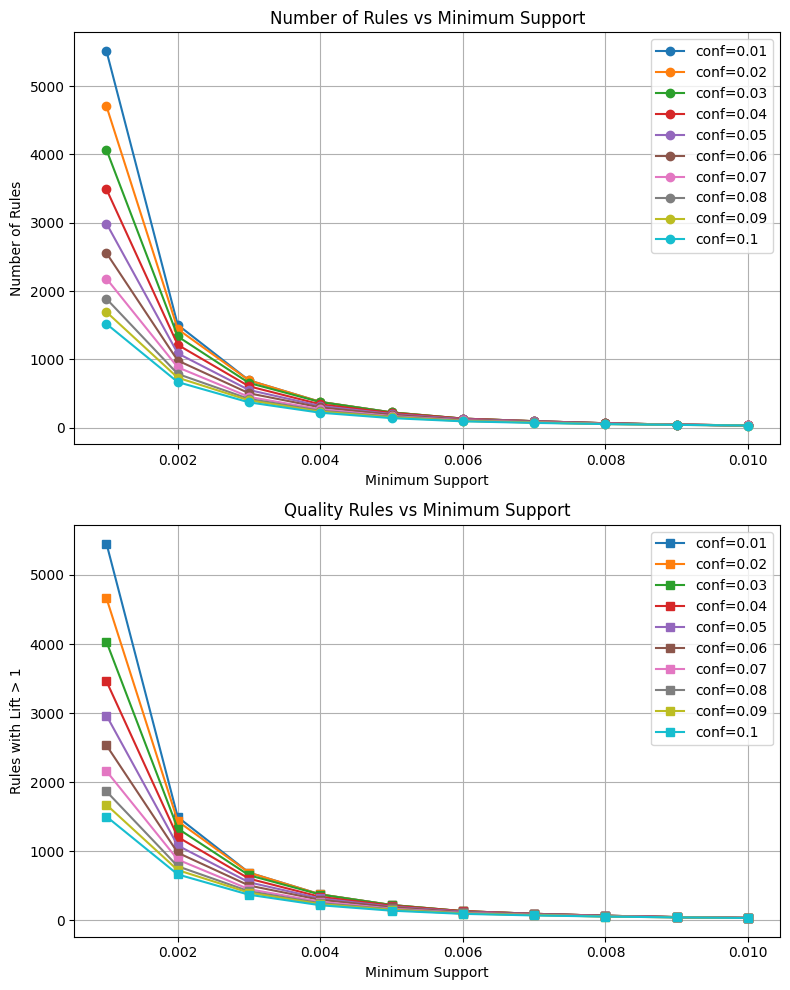

In [11]:
# minsup_list = [0.001, 0.004, 0.007, 0.01]
# minconf_list = [0.01, 0.04, 0.07, 0.1]

minsup_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
minconf_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
results = []
for minsup in minsup_list:
    print(f"Testing min_support = {minsup}")
    try:
        min_support_count = int(minsup * len(train_tx))
        if min_support_count < 1:
            min_support_count = 1
        
        # Mine frequent itemsets
        frequent_itemsets = fp_growth(train_tx, min_support_count)
        
        if not frequent_itemsets:
            continue
        
        # Test each confidence threshold
        for minconf in minconf_list:
            rules_tmp = generate_association_rules_CORRECT(frequent_itemsets, train_tx, minconf)
            # Filter to single-item antecedents
            rules_tmp = [rule for rule in rules_tmp if len(rule['antecedent']) == 1]
            
            n_with_lift_gt1 = sum(1 for rule in rules_tmp if rule['lift'] > 1)
            
            results.append({
                'minsup': minsup,
                'minconf': minconf,
                'n_rules': len(rules_tmp),
                'n_frequent_itemsets': len(frequent_itemsets),
                'n_with_lift_gt1': n_with_lift_gt1
            })
    except Exception as e:
        print(f"Error with min_support {minsup}: {e}")

res_df = pd.DataFrame(results)
print("Results:")
display(res_df)

plt.figure(figsize=(8, 10))  # taller figure for vertical layout

plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
for minconf in minconf_list:
    subset = res_df[res_df['minconf'] == minconf]
    if len(subset) > 0:
        plt.plot(subset['minsup'], subset['n_rules'], 'o-', label=f'conf={minconf}')
plt.xlabel('Minimum Support')
plt.ylabel('Number of Rules')
plt.title('Number of Rules vs Minimum Support')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
for minconf in minconf_list:
    subset = res_df[res_df['minconf'] == minconf]
    if len(subset) > 0:
        plt.plot(subset['minsup'], subset['n_with_lift_gt1'], 's-', label=f'conf={minconf}')
plt.xlabel('Minimum Support')
plt.ylabel('Rules with Lift > 1')
plt.title('Quality Rules vs Minimum Support')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Part C: Recommendation and Evaluation

### 1: Generate Rule Lists


In [12]:
# 1. Top 100 rules by support
top_support_rules = rules_df.sort_values('support', ascending=False).head(100).copy()

# 2. Top 100 rules by confidence
top_confidence_rules = rules_df.sort_values('confidence', ascending=False).head(100).copy()

# 3. Identify rules that appear in both lists
def rule_signature(row):
    return (row['antecedent_name'], tuple(sorted(row['consequents_list'])))

top_support_rules['signature'] = top_support_rules.apply(rule_signature, axis=1)
top_confidence_rules['signature'] = top_confidence_rules.apply(rule_signature, axis=1)

# Find intersection
common_signatures = set(top_support_rules['signature']).intersection(top_confidence_rules['signature'])
common_rules = rules_df[rules_df.apply(lambda row: rule_signature(row) in common_signatures, axis=1)]

# Save top-100 rules by confidence to a text file
top_confidence_rules[['antecedent_name', 'consequents_list', 'support', 'confidence', 'lift']].to_csv('30_top100RulesByConf.txt', index=False, sep='\t')

# Save top-100 rules by support to a text file
top_support_rules[['antecedent_name', 'consequents_list', 'support', 'confidence', 'lift']].to_csv('30_top100RulesBySup.txt', index=False, sep='\t')

# Display results
print(f"Number of rules in both top-100 lists: {len(common_rules)}")
display(common_rules[['antecedent_name','consequents_list','support','confidence','lift']])

Number of rules in both top-100 lists: 30


,antecedent_name,consequents_list,support,confidence,lift
182,Organic Fuji Apple,[Banana],0.009241,0.366591,2.574083
209,Honeycrisp Apple,[Banana],0.009212,0.341575,2.398431
167,Organic Large Extra Fancy Fuji Apple,[Bag of Organic Bananas],0.007574,0.339598,2.866868
470,Organic Hass Avocado,[Bag of Organic Bananas],0.018415,0.330258,2.788016
434,Organic Raspberries,[Bag of Organic Bananas],0.013547,0.319192,2.694597
139,Broccoli Crown,[Banana],0.006964,0.316862,2.224900
201,Organic Lemon,[Bag of Organic Bananas],0.008117,0.304721,2.572435
431,Organic Raspberries,[Organic Strawberries],0.012861,0.303030,3.620738
483,Organic Avocado,[Banana],0.017053,0.297688,2.090270
458,Strawberries,[Banana],0.014443,0.294198,2.065759


### 2. Implement Evaluation Logic


In [13]:
# Create a lookup: antecedent -> [(consequents_list, confidence)]
rule_dict = defaultdict(list)
for _, row in rules_df.iterrows():
    rule_dict[row['antecedent_name']].append((row['consequents_list'], row['confidence']))

# Function to generate recommendations given input basket
def recommend_from_rules(input_items, top_k=10):
    candidates = {}
    for item in input_items:
        if item in rule_dict:
            for consequents, conf in rule_dict[item]:
                for c in consequents:
                    if c not in input_items:  # avoid recommending already present items
                        candidates[c] = max(candidates.get(c, 0), conf)  # take highest confidence
    # Sort by confidence and return top_k
    return [c for c, _ in sorted(candidates.items(), key=lambda x: x[1], reverse=True)[:top_k]]

# Split each test transaction into input and ground truth
test_pairs = []
for tx in test_tx:
    tx = [id_to_name.get(i, f'Unknown_{i}') for i in tx if i in id_to_name] 
    if len(tx) >= 2:
        mid = len(tx) // 2
        input_items = tx[:mid]
        ground_truth = tx[mid:]
        test_pairs.append((input_items, ground_truth))

print(f"Total test transactions considered: {len(test_pairs)}")

Total test transactions considered: 24838


### 3. Calculate and Plot Metrics

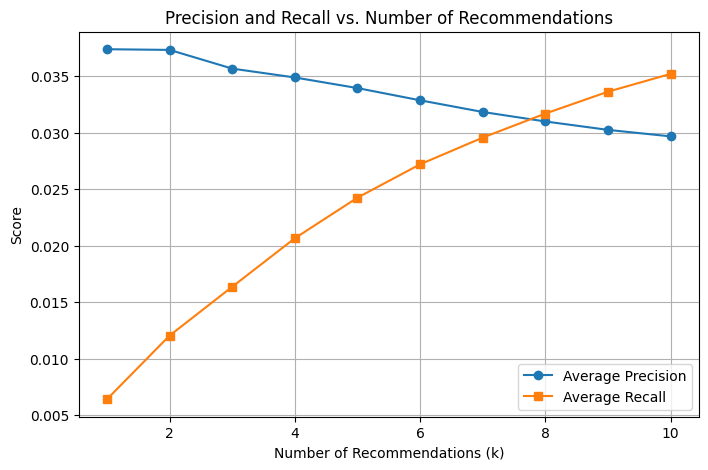

Average Precision: [0.03740236734036557, 0.03734197600450922, 0.035684569342673854, 0.034899481976541316, 0.03395939018171082, 0.03287771425503932, 0.03184339280442026, 0.031002227769278256, 0.03025740129371662, 0.029681223215324192]
Average Recall: [0.0063953289348385655, 0.012029689372766056, 0.01635832225881724, 0.020655369875139985, 0.024251703304830938, 0.027205344291306104, 0.02957252819673133, 0.031701443392948475, 0.03363898586663482, 0.035217806921243794]


In [14]:
k_values = range(1, 11)
avg_precision = []
avg_recall = []

for k in k_values:
    precision_scores = []
    recall_scores = []

    for input_items, ground_truth in test_pairs:
        if not ground_truth:
            continue

        recs = recommend_from_rules(input_items, top_k=k)

        hits = len(set(recs) & set(ground_truth))
        precision = hits / len(recs) if recs else 0
        recall = hits / len(ground_truth) if ground_truth else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision.append(np.mean(precision_scores))
    avg_recall.append(np.mean(recall_scores))

# Plot Precision and Recall vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_precision, 'o-', label='Average Precision')
plt.plot(k_values, avg_recall, 's-', label='Average Recall')
plt.xlabel('Number of Recommendations (k)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Number of Recommendations')
plt.legend()
plt.grid(True)
plt.show()

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)

### 4. Sample Analysis

Sample transaction indices: [18488, 7229, 5342, 22507, 22345]


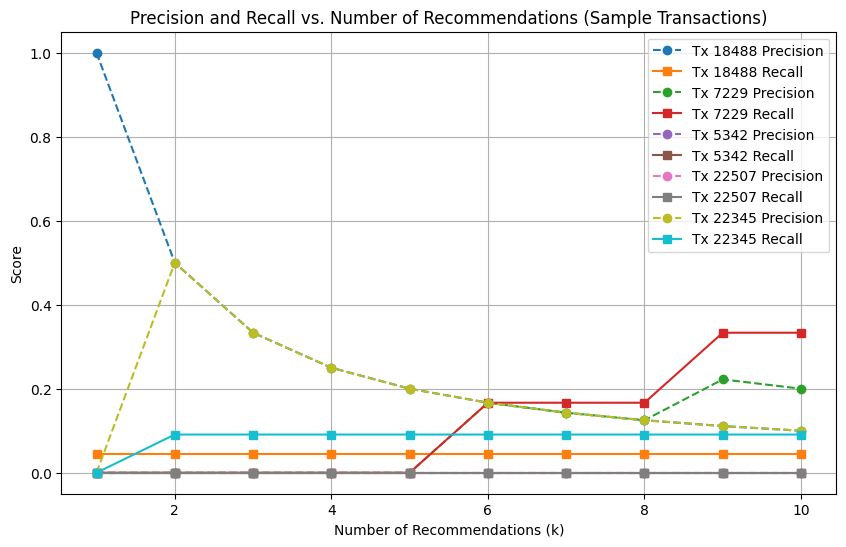


===== Tx 18488 =====
k	Precision	Recall
1	1.0000		0.0455
2	0.5000		0.0455
3	0.3333		0.0455
4	0.2500		0.0455
5	0.2000		0.0455
6	0.1667		0.0455
7	0.1429		0.0455
8	0.1250		0.0455
9	0.1111		0.0455
10	0.1000		0.0455

===== Tx 7229 =====
k	Precision	Recall
1	0.0000		0.0000
2	0.0000		0.0000
3	0.0000		0.0000
4	0.0000		0.0000
5	0.0000		0.0000
6	0.1667		0.1667
7	0.1429		0.1667
8	0.1250		0.1667
9	0.2222		0.3333
10	0.2000		0.3333

===== Tx 5342 =====
k	Precision	Recall
1	0.0000		0.0000
2	0.0000		0.0000
3	0.0000		0.0000
4	0.0000		0.0000
5	0.0000		0.0000
6	0.0000		0.0000
7	0.0000		0.0000
8	0.0000		0.0000
9	0.0000		0.0000
10	0.0000		0.0000

===== Tx 22507 =====
k	Precision	Recall
1	0.0000		0.0000
2	0.0000		0.0000
3	0.0000		0.0000
4	0.0000		0.0000
5	0.0000		0.0000
6	0.0000		0.0000
7	0.0000		0.0000
8	0.0000		0.0000
9	0.0000		0.0000
10	0.0000		0.0000

===== Tx 22345 =====
k	Precision	Recall
1	0.0000		0.0000
2	0.5000		0.0909
3	0.3333		0.0909
4	0.2500		0.0909
5	0.2000		0.0909
6	0.1667		0.0909
7	0.1429		0

In [15]:
# Set a seed for reproducibility
random.seed(7772) 

# Pick a few random test transactions
sample_tx_indices = random.sample(range(len(test_pairs)), 5)
print("Sample transaction indices:", sample_tx_indices)

user_precision = {}
user_recall = {}

for idx in sample_tx_indices:
    input_items, ground_truth = test_pairs[idx]

    k_values = range(1, 11)
    precision_scores = []
    recall_scores = []

    for k in k_values:
        recs = recommend_from_rules(input_items, top_k=k)
        hits = len(set(recs) & set(ground_truth))
        precision = hits / len(recs) if recs else 0
        recall = hits / len(ground_truth) if ground_truth else 0
        precision_scores.append(precision)
        recall_scores.append(recall)

    user_precision[f"Tx {idx}"] = precision_scores
    user_recall[f"Tx {idx}"] = recall_scores

plt.figure(figsize=(10, 6))
for user in user_precision:
    plt.plot(range(1, 11), user_precision[user], 'o--', label=f'{user} Precision')
    plt.plot(range(1, 11), user_recall[user], 's-', label=f'{user} Recall')

plt.xlabel('Number of Recommendations (k)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Number of Recommendations (Sample Transactions)')
plt.legend()
plt.grid(True)
plt.show()

# Print precision and recall values for each sampled transaction
for user in user_precision:
    print(f"\n===== {user} =====")
    print("k\tPrecision\tRecall")
    for k, (p, r) in enumerate(zip(user_precision[user], user_recall[user]), start=1):
        print(f"{k}\t{p:.4f}\t\t{r:.4f}")


### Word Cloud of Most Frequently Purchased Products

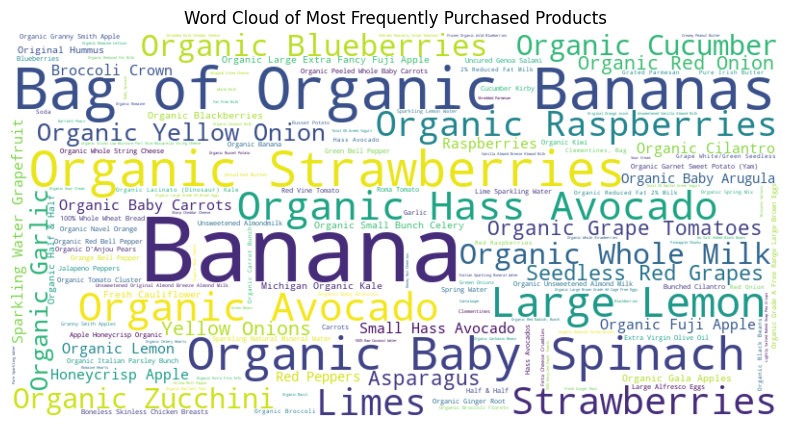

Top 5 Most Frequently Purchased Products:
Banana: 18726 purchases
Bag of Organic Bananas: 15480 purchases
Organic Strawberries: 10894 purchases
Organic Baby Spinach: 9784 purchases
Large Lemon: 8135 purchases


In [16]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Count product frequencies
product_counts = Counter(op_train['product_id'])
product_names = {row['product_id']: row['product_name'] for _, row in products.iterrows()}
product_freq = {product_names[pid]: count for pid, count in product_counts.items() if pid in product_names}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(product_freq)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequently Purchased Products")
plt.show()

# Get the top 5 products by frequency
top_5_products = sorted(product_freq.items(), key=lambda x: x[1], reverse=True)[:5]

# Display the top 5 products
print("Top 5 Most Frequently Purchased Products:")
for product, count in top_5_products:
    print(f"{product}: {count} purchases")
